The below code generates a tiff file with instance-segmentation (ie each nucleus has its own unique integer) masks of the nuclei in the input ome tiff. This mask should then be passed through the next step (generating a QuPath project with the mask as annotations using a local script). The below code assumes you have at least 75 GB of RAM and a GPU (and therefore CUDA + cuDNN + tensorflow compatability.

## Imports

In [1]:
from deepcell.applications import Mesmer
from deepcell.utils.plot_utils import create_rgb_image
from deepcell.utils.plot_utils import make_outline_overlay
import skimage.io as io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# replace the file path with your image's
folder = "data/ome-tiffs/"
file_name = "RAM13_003-Brain_131199-2.ome.tif"
file_path = folder + file_name

In [ ]:
# read the image
image = io.imread(file_path)

### Optional: Check if GPU is Accessible

In [2]:
# should say at least 1 GPU available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
# let's check the GPU is on (it should output '/device:GPU:0').

tf.test.gpu_device_name()

2023-07-21 19:43:38.702025: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/device:GPU:0'

2023-07-21 19:43:42.437249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 9642 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-07-21 19:43:42.453713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 9642 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5


In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [8]:
!module li

Currently Loaded Modulefiles:
 1) IDRE   2) intel/2020.4   3) cuda/11.0   4) anaconda3/2020.11  

Key:
default-version  
>

## Image Pre-Processing

In [5]:
# we must add an extra axis to fit the parameter requirements
# the extra axis is the batch, but we won't care about that
image = np.expand_dims(image, axis=0)
image.shape

(1, 23926, 16892, 8)

### Optional: Visualize Channel(s)

In [6]:
# at least create the DAPI image. The other channels are commented
# out for efficiency, but you may display them just as you display
# rgb_image1 if you so choose.

# rgb_image8 = create_rgb_image(image[:,:,:,7:], channel_colors=['blue'])
# rgb_image7 = create_rgb_image(image[:,:,:,6:7], channel_colors=['blue'])
# rgb_image6 = create_rgb_image(image[:,:,:,5:6], channel_colors=['blue'])
# rgb_image5 = create_rgb_image(image[:,:,:,4:5], channel_colors=['blue'])
# rgb_image4 = create_rgb_image(image[:,:,:,3:4], channel_colors=['blue'])
# rgb_image3 = create_rgb_image(image[:,:,:,2:3], channel_colors=['blue'])
# rgb_image2 = create_rgb_image(image[:,:,:,1:2], channel_colors=['green'])
rgb_image1 = create_rgb_image(image[:,:,:,0:1], channel_colors=['blue'])

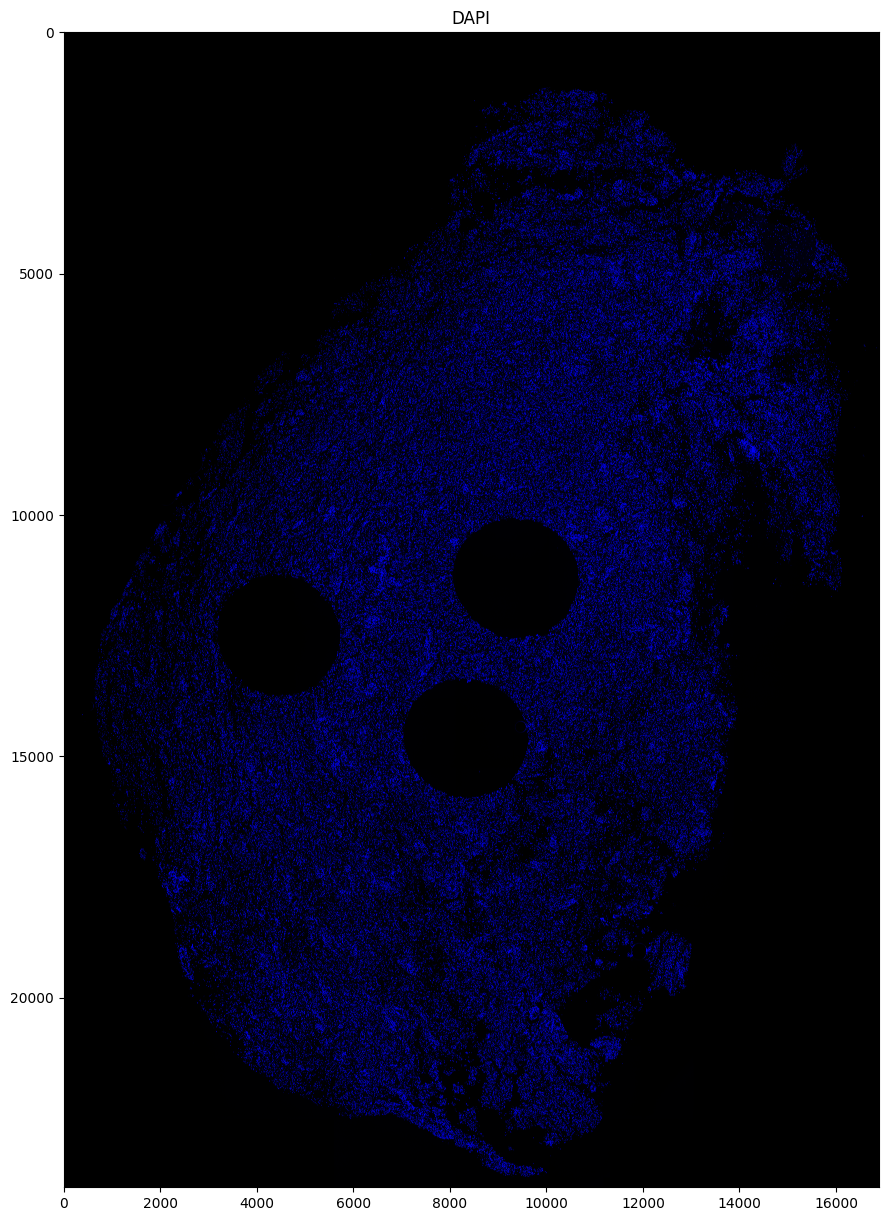

In [7]:
# Let's look at the DAPI
# select channel index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(rgb_image1[idx, ...])

ax.set_title('DAPI')

plt.show()

## Make Predictions

In [9]:
# perform nuclear segmentation
# this usually takes 14 minutes and will use up 75 GB of RAM

app = Mesmer()
labeled_image = app.predict(image[:,:,:,0:2], image_mpp=app.model_mpp, compartment='nuclear')

96894976/96885295 [==============================] - 5s 0us/step


2023-07-21 19:47:33.484988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9642 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-07-21 19:47:33.487206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9642 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5


2023-07-21 19:49:26.412547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-07-21 19:49:31.514803: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
/u/home/s/sperrott/.conda/envs/DEEPCELL/lib/python3.10/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


### Optional: Make RGB Overlay and Visualize Overlay

In [10]:
# make the RGB overlay for optional visualization
overlay_data_nuc_big = make_outline_overlay(rgb_data=rgb_image1, predictions=labeled_image)

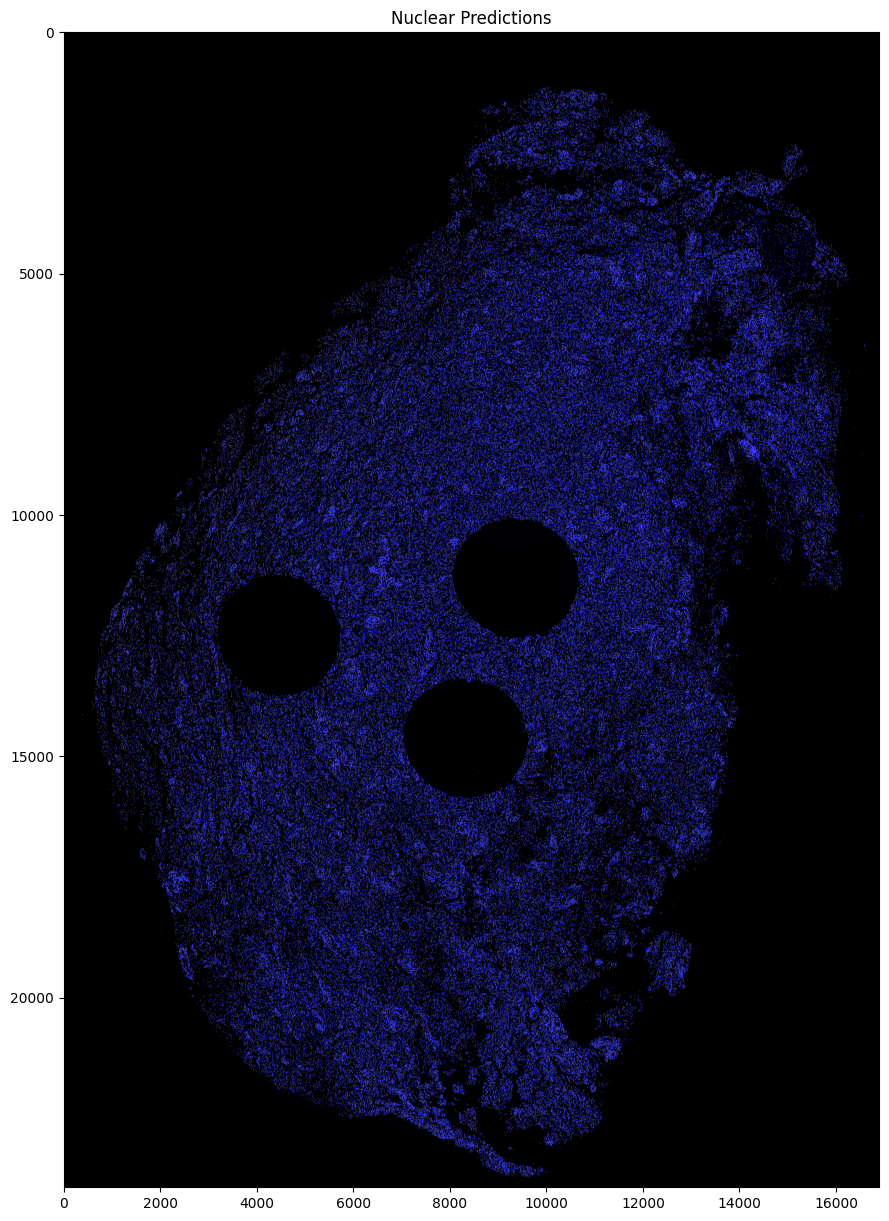

In [11]:
# optional
# display the overlay
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(overlay_data_nuc_big[idx, ...])
ax.set_title('Nuclear Predictions')
plt.show()

## Save Mask to Folder

In [12]:
# we don't need the extra batch and channel dimensions for the mask
squeezed_array_big = np.squeeze(labeled_image[0,:,:,:])

In [15]:
# save the mask
import skimage.io as io
io.imsave("data/masks/ome_mask_2D.tif", squeezed_array_big, plugin="tifffile", bigtiff=True)

/tmp/ipykernel_133954/2744560385.py:3: UserWarning: data/masks/ome_mask_2D.tif is a low contrast image
  io.imsave("data/masks/ome_mask_2D.tif", squeezed_array_big, plugin="tifffile", bigtiff=True)


### Optional: Visualizing the Mask

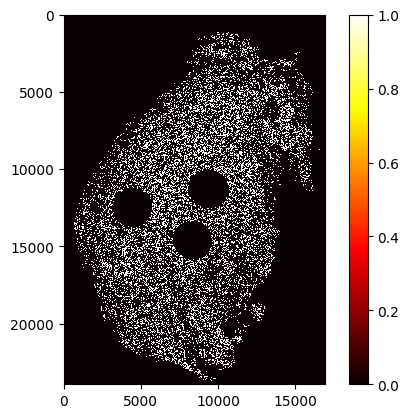

In [13]:
# optional: if you want to view the mask
binary_mask_big = (squeezed_array_big > 0).astype(int)

plt.imshow(binary_mask_big, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [14]:
# optional: if you want to see how many cells detected
max_value = np.max(squeezed_array_big)
print(max_value)

254313
